## Pairs trading using pca approach (XLK ETF)

Imports

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from statsmodels.tsa.stattools import coint
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage,dendrogram
import warnings
warnings.filterwarnings('ignore')

Load Data

In [2]:
tickers=["NVDA","AAPL","MSFT","AVGO","AMD","CSCO","IBM","ORCL","CRM","LRCX","AMAT",
         "QCOM","INTU","ACN","TXN","NOW","INTC","APH","ADBE","ADI","ANET","PANW","CDNS",
         "SNPS","GLW","TEL","ADSK","MSI","WDC","NXPI","FTNT","ROP","WDAY","MPWR","FICO",
         "CTSH","MCHP","HPE","TER","FSLR","TDY","JBL","ON","NTAP","HPQ","TYL","TRMB",
         "IT","CDW","GDDY","GEN","FFIV","SMCI","ZBRA","AKAM","EPAM","SWKS"]

In [3]:
df=yf.download(tickers=tickers,start='2015-01-01',auto_adjust=False,timeout=60,threads=False)

[*********************100%***********************]  57 of 57 completed


In [4]:
df.head()

Price       Adj Close                                                         \
Ticker           AAPL        ACN       ADBE        ADI       ADSK       AKAM   
Date                                                                           
2015-01-02  24.237547  74.252609  72.339996  44.354481  59.529999  63.250000   
2015-01-05  23.554735  72.998901  71.980003  43.547901  58.660000  61.939999   
2015-01-06  23.556957  72.472359  70.529999  42.525688  57.500000  60.669998   
2015-01-07  23.887280  73.993523  71.110001  42.972916  57.380001  60.160000   
2015-01-08  24.805082  75.121872  72.919998  43.731583  58.799999  61.570000   

Price                                             ...   Volume          \
Ticker           AMAT   AMD      ANET        APH  ...     SWKS     TDY   
Date                                              ...                    
2015-01-02  21.764576  2.67  3.917500  12.086211  ...  2850200  145700   
2015-01-05  21.066990  2.66  3.987500  11.865397  ...  2924500  266200   
2015-01-06  20.273491  2.63  3.988125  11.714434  ...  4746300  243000   
2015-01-07  20.465326  2.58  4.071250  11.914968  ...  2896200  245300   
2015-01-08  21.119308  2.61  4.132500  12.147048  ...  3773000  240300   

Price                                                                     \
Ticker          TEL      TER     TRMB      TXN     TYL     WDAY      WDC   
Date                                                                       
2015-01-02   948900  1030300  1106000  4020100  216200  1630000  1278547   
2015-01-05   953400  1877000  1254900  5599300  270300  1591400  2199752   
2015-01-06  1448800  2377700  2291600  5468400  239600  1584000  2665713   
2015-01-07  1929000   902400  2096400  4577100  220300  1106100  2054222   
2015-01-08  1635300  1626800  2036000  6295200  264700  2090100  3351291   

Price               
Ticker        ZBRA  
Date                
2015-01-02  411800  
2015-01-05  420300  
2015-01-06  527500  
2015-01-07  467800  
2015-01-08  324400  

[5 rows x 342 columns]

Clean the data

* Check for missing values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2760 entries, 2015-01-02 to 2025-12-22
Columns: 342 entries, ('Adj Close', 'AAPL') to ('Volume', 'ZBRA')
dtypes: float64(288), int64(54)
memory usage: 7.2 MB


Good so no missing or NaN values to worry about.

* We only need Adj Close from the data, take log instead of raw values for better pca alignment.

In [6]:
prices=np.log(df['Adj Close']).diff()

In [7]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2760 entries, 2015-01-02 to 2025-12-22
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2759 non-null   float64
 1   ACN     2759 non-null   float64
 2   ADBE    2759 non-null   float64
 3   ADI     2759 non-null   float64
 4   ADSK    2759 non-null   float64
 5   AKAM    2759 non-null   float64
 6   AMAT    2759 non-null   float64
 7   AMD     2759 non-null   float64
 8   ANET    2759 non-null   float64
 9   APH     2759 non-null   float64
 10  AVGO    2759 non-null   float64
 11  CDNS    2759 non-null   float64
 12  CDW     2759 non-null   float64
 13  CRM     2759 non-null   float64
 14  CSCO    2759 non-null   float64
 15  CTSH    2759 non-null   float64
 16  EPAM    2759 non-null   float64
 17  FFIV    2759 non-null   float64
 18  FICO    2759 non-null   float64
 19  FSLR    2759 non-null   float64
 20  FTNT    2759 non-null   float64
 21  GDDY    2699 non-nu

Split the data into train and test now.

In [8]:
train=prices[:2300]
test=prices[2300:]

In [9]:
train.dropna(inplace=True)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2099 entries, 2015-10-20 to 2024-02-22
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2099 non-null   float64
 1   ACN     2099 non-null   float64
 2   ADBE    2099 non-null   float64
 3   ADI     2099 non-null   float64
 4   ADSK    2099 non-null   float64
 5   AKAM    2099 non-null   float64
 6   AMAT    2099 non-null   float64
 7   AMD     2099 non-null   float64
 8   ANET    2099 non-null   float64
 9   APH     2099 non-null   float64
 10  AVGO    2099 non-null   float64
 11  CDNS    2099 non-null   float64
 12  CDW     2099 non-null   float64
 13  CRM     2099 non-null   float64
 14  CSCO    2099 non-null   float64
 15  CTSH    2099 non-null   float64
 16  EPAM    2099 non-null   float64
 17  FFIV    2099 non-null   float64
 18  FICO    2099 non-null   float64
 19  FSLR    2099 non-null   float64
 20  FTNT    2099 non-null   float64
 21  GDDY    2099 non-nu

* Checking for sum of missing values in train for each feature/security.

In [11]:
missing_df = (
    train.isnull().sum()
      .reset_index()
      .rename(columns={"index": "Feature", 0: "Missing"})
)

missing_df = missing_df[missing_df["Missing"] > 0].sort_values("Missing", ascending=False)
missing_df


,Ticker,Missing


--- So no missing values in train.

* Normalize by Z-scoring

In [12]:
nor_t=(train-train.mean())/train.std()

Use PCA to take components that matter

In [13]:
pca=PCA()
pca.fit_transform(nor_t)

array([[-0.46832488, -0.17266662, -0.82299523, ...,  0.10335602,
        -0.24167979, -0.31918399],
       [-4.11911617, -0.24637263, -1.4583749 , ...,  0.87523656,
        -0.42436768, -0.63701677],
       [10.01793807, -0.32194009,  0.8121805 , ..., -0.62260348,
         1.88756547, -0.47814583],
       ...,
       [-3.05474459, -0.83667878,  0.46372205, ..., -0.38008617,
        -0.54782098, -0.75015732],
       [-2.74419211, -3.55300404, -0.48117587, ...,  0.42713826,
        -0.3489711 ,  0.13333538],
       [ 8.65785494,  1.04291729, -0.72391967, ...,  0.63979807,
         0.26743593,  0.0443861 ]], shape=(2099, 57))

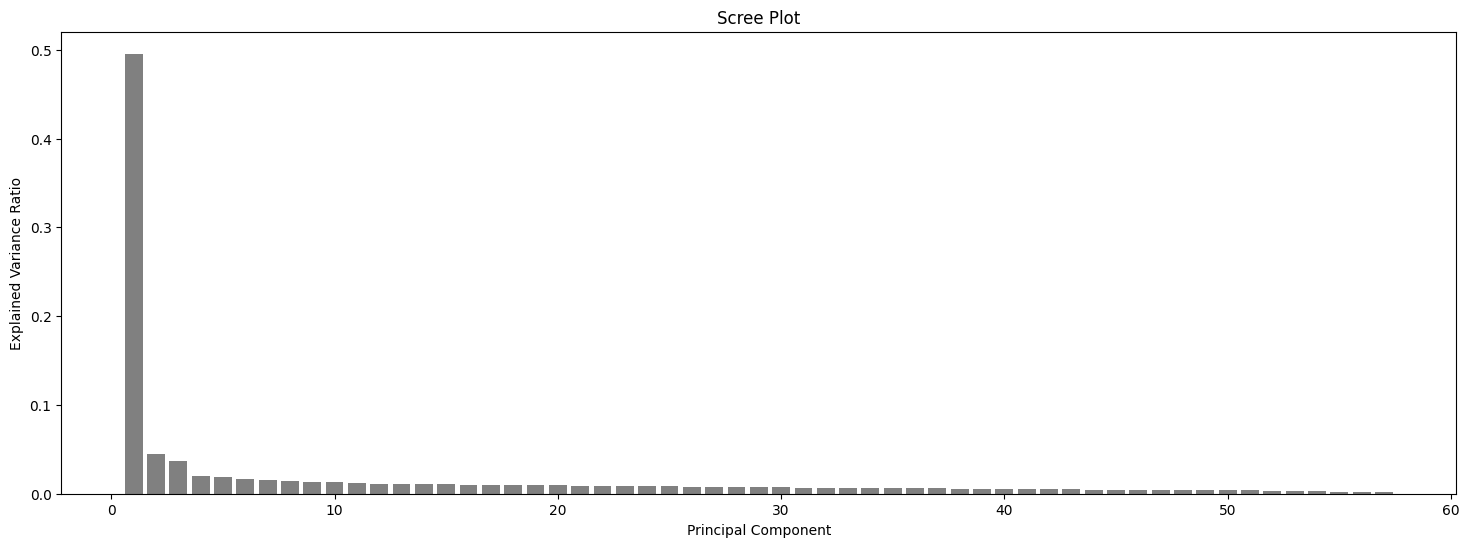

In [14]:
explained_var = pca.explained_variance_ratio_
plt.figure(figsize=(18,6))
plt.bar(
    np.arange(1, len(explained_var) + 1),
    explained_var,color='grey'
)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.show()

Observe that component 1 and 2 have the most explained variance ratio, so now we have our k =1 & 2

* Inspect loadings

In [15]:
loadings=pd.DataFrame(pca.components_.T,index=nor_t.columns)

In [16]:
loadings

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
Ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,0.141750,0.058121,-0.009442,0.137871,-0.115584,-0.076719,-0.012815,-0.075781,0.111143,0.056412,...,-0.147883,0.147858,0.130841,-0.370949,-0.093044,-0.080498,-0.012930,0.011827,0.026130,0.024117
ACN,0.148134,0.040632,0.189832,-0.065874,-0.163773,-0.025232,0.006053,0.023398,0.027875,0.062912,...,0.333459,0.088086,-0.206267,0.036939,-0.379020,0.064088,0.082620,0.098433,-0.005208,-0.016184
ADBE,0.144073,0.239797,-0.016843,0.052524,-0.080887,-0.018249,0.011463,-0.026356,0.019638,0.088897,...,0.287065,-0.221711,0.280772,-0.019149,-0.384634,0.015167,-0.058800,-0.002172,-0.014025,-0.007277
ADI,0.156172,-0.111718,-0.175001,-0.011671,-0.085782,-0.123332,0.026973,-0.058919,-0.015986,-0.013064,...,0.092167,-0.082100,-0.125814,-0.159366,0.040806,-0.125352,0.788389,-0.021696,0.132580,-0.023606
ADSK,0.142416,0.130202,-0.001373,-0.071676,0.046887,-0.060696,-0.057263,0.074759,-0.074098,0.026289,...,-0.028289,0.015084,-0.012508,-0.030633,0.075341,0.033980,0.015009,-0.003148,0.008222,-0.003654
AKAM,0.091614,0.126510,0.127487,0.298395,0.084582,-0.156511,0.042866,0.217242,-0.323764,-0.036904,...,-0.016521,0.043573,0.008675,-0.035216,-0.007278,-0.005449,0.040231,-0.010718,0.001735,-0.000450
AMAT,0.154533,-0.100942,-0.201249,0.067341,-0.048874,-0.005436,0.015119,-0.007977,-0.010227,0.000831,...,-0.063674,0.007273,0.138027,0.044431,-0.078084,-0.114628,0.038168,0.079573,-0.021337,0.700242
AMD,0.114080,0.048366,-0.162462,0.155475,0.039360,0.198265,-0.012173,0.119666,0.051968,-0.299906,...,0.106928,-0.054313,-0.012303,0.077229,0.037928,0.019659,0.001483,0.011005,-0.007485,0.004123
ANET,0.115071,0.075596,0.022834,0.187606,0.181771,0.155993,-0.209541,0.186253,0.166672,-0.283917,...,0.046574,-0.050369,0.010608,-0.052781,-0.015053,-0.003160,-0.001666,0.002564,0.014410,0.010813


PC1

In [17]:
pc1_loadings=loadings.iloc[:, 0].sort_values(key=abs, ascending=False)
print(pc1_loadings)

Ticker
APH     0.158075
MCHP    0.157655
TXN     0.156881
ADI     0.156172
AMAT    0.154533
MPWR    0.154261
LRCX    0.153298
TEL     0.151152
MSFT    0.150998
SWKS    0.150410
SNPS    0.150357
INTU    0.148456
ACN     0.148134
CDNS    0.147762
TER     0.146931
AVGO    0.146733
ON      0.145071
ADBE    0.144073
ADSK    0.142416
NXPI    0.141967
AAPL    0.141750
NVDA    0.139583
CDW     0.138836
GLW     0.135663
JBL     0.134817
TRMB    0.134279
CRM     0.133872
FICO    0.133000
NOW     0.132898
QCOM    0.131876
INTC    0.131296
CSCO    0.130945
WDAY    0.128468
ROP     0.127764
CTSH    0.127647
TDY     0.126421
HPQ     0.124982
ZBRA    0.124626
FFIV    0.124471
WDC     0.124327
TYL     0.123270
IT      0.120366
NTAP    0.120267
GDDY    0.119549
MSI     0.119180
HPE     0.117918
FTNT    0.117719
ORCL    0.115226
ANET    0.115071
AMD     0.114080
EPAM    0.110680
IBM     0.109440
PANW    0.100772
AKAM    0.091614
FSLR    0.085731
SMCI    0.080661
GEN     0.075084
Name: 0, dtype: float64


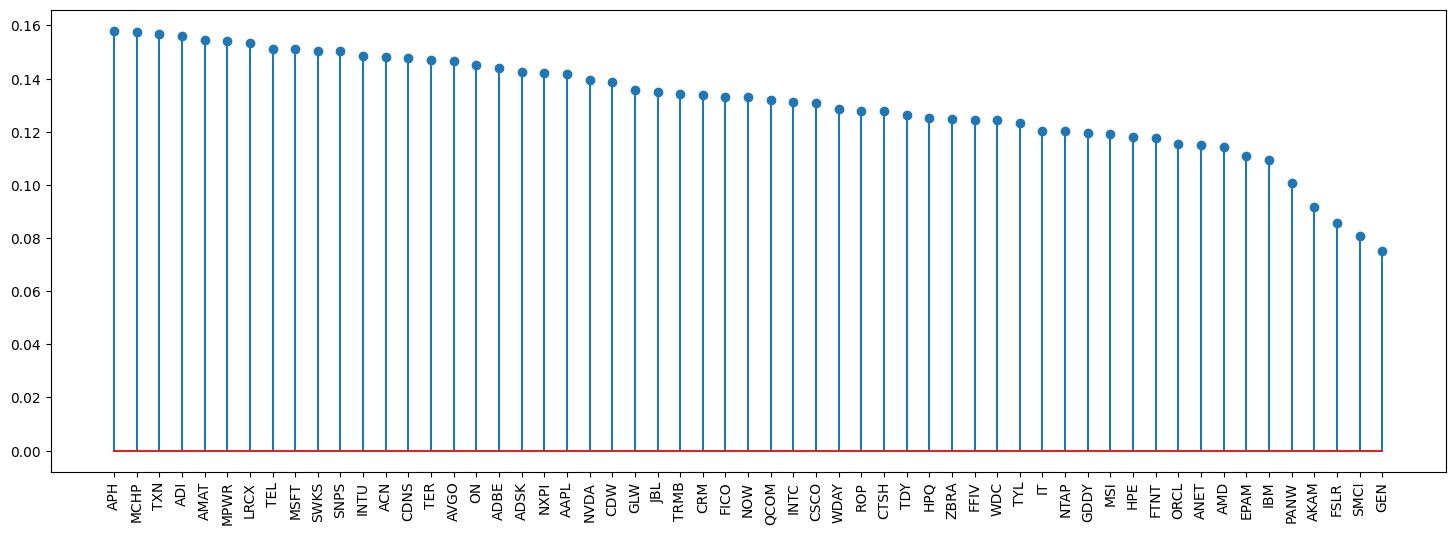

In [18]:
plt.figure(figsize=(18,6))
plt.stem(pc1_loadings.index,pc1_loadings.values)
plt.xticks(rotation=90)
plt.show()

In [19]:
pc2_loadings=loadings.iloc[:,1].sort_values(key=abs,ascending=False)
print(pc2_loadings)

Ticker
NOW     0.283571
CRM     0.242891
ADBE    0.239797
WDAY    0.236058
TYL     0.224262
HPE    -0.220049
PANW    0.200739
FTNT    0.191053
HPQ    -0.182119
INTU    0.180211
JBL    -0.180101
SNPS    0.176113
WDC    -0.172375
TEL    -0.165175
IBM    -0.163667
MSFT    0.158977
CDNS    0.156683
ON     -0.150304
NXPI   -0.148855
GLW    -0.146978
MCHP   -0.135950
ADSK    0.130202
NTAP   -0.126797
AKAM    0.126510
GDDY    0.123530
FICO    0.113461
ADI    -0.111718
APH    -0.111462
AMAT   -0.100942
TXN    -0.100409
TER    -0.096471
LRCX   -0.093768
SWKS   -0.092944
EPAM    0.090575
INTC   -0.084549
TDY    -0.083422
NVDA    0.082335
SMCI   -0.075859
ANET    0.075596
AVGO   -0.069402
CDW    -0.066025
GEN     0.058251
AAPL    0.058121
QCOM   -0.057488
CSCO   -0.050649
AMD     0.048366
TRMB   -0.046456
ORCL    0.044818
ACN     0.040632
CTSH   -0.038434
ZBRA   -0.030208
FSLR   -0.029215
FFIV   -0.029139
ROP     0.017103
MSI     0.015052
MPWR   -0.009249
IT      0.002249
Name: 1, dtype: float64


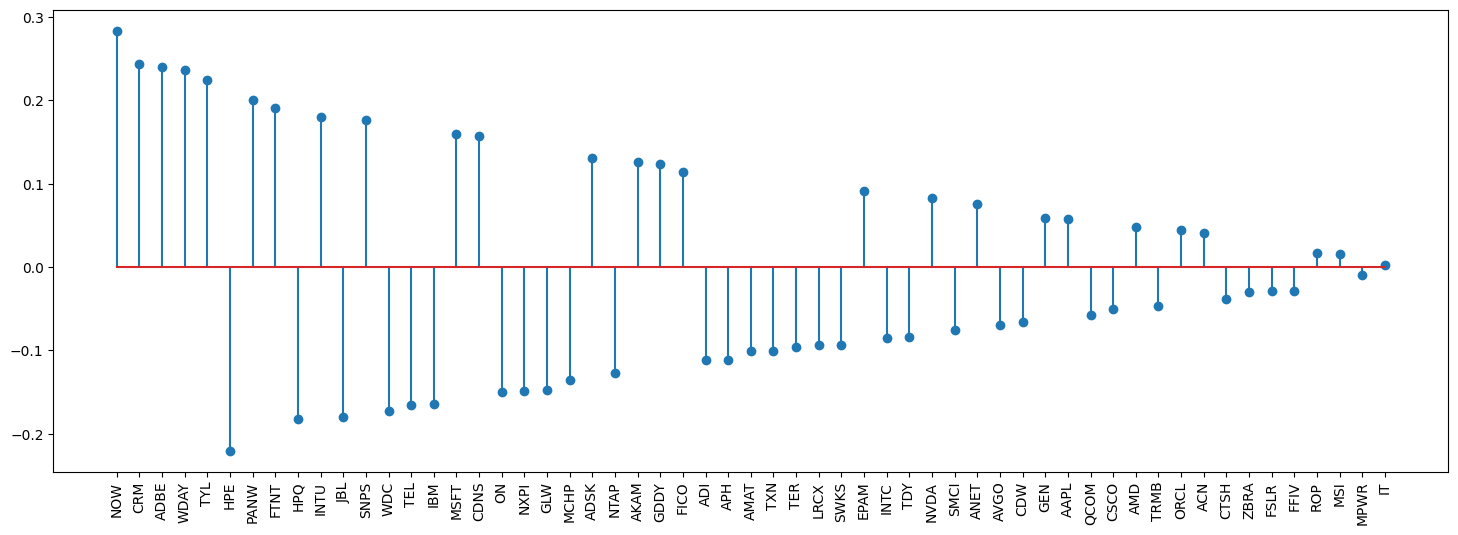

In [20]:
plt.figure(figsize=(18,6))
plt.stem(pc2_loadings.index,pc2_loadings.values)
plt.xticks(rotation=90)
plt.show()

Analysis part ends here, we just need to observe realtionships between orgs. to compute and have real pairs we need distnace matrix, clustering and cointegration...

* Distance Matrix

In [21]:
corr=nor_t.corr()
dist=1-corr
distv=squareform(dist.values)

* Clustering

In [24]:
link=linkage(distv,method='ward')

model=AgglomerativeClustering(n_clusters=3,linkage='ward')
labels=model.fit_predict(dist)
clusters = pd.Series(labels, index=nor_t.columns)
clusters.value_counts()

0    27
2    20
1    10
Name: count, dtype: int64

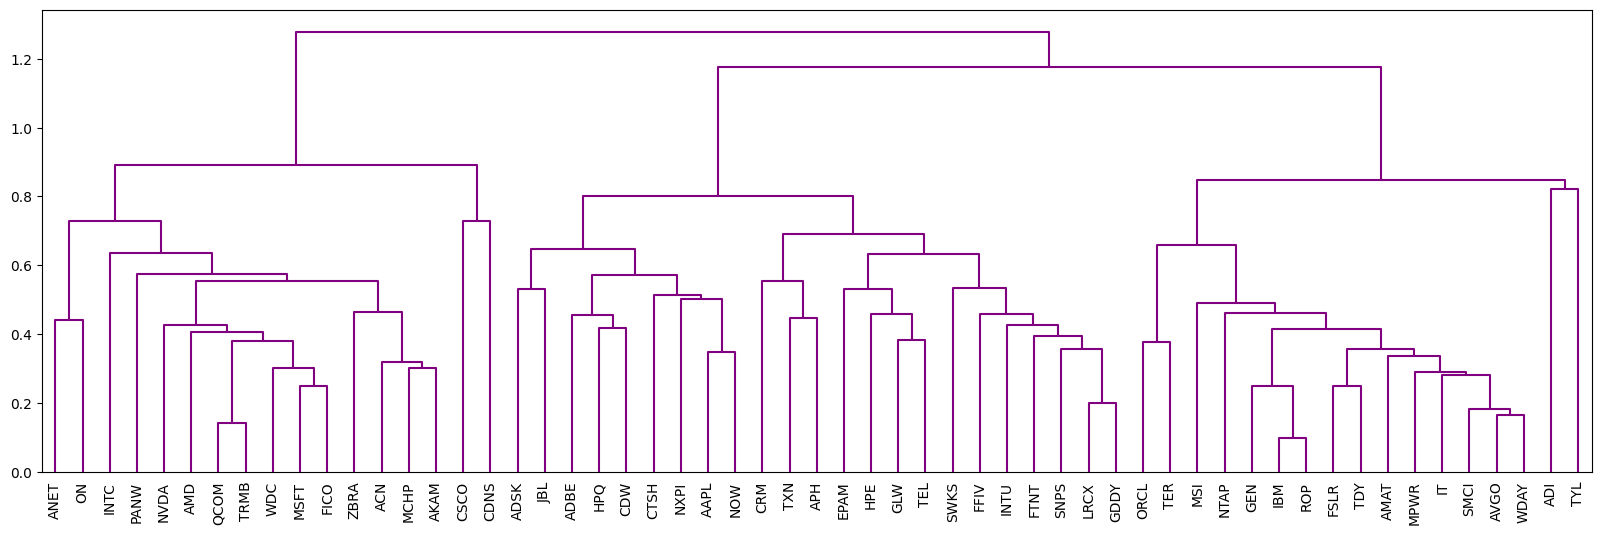

In [25]:
plt.figure(figsize=(20,6))
dendrogram(
    link,
    labels=tickers,
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=False,
    above_threshold_color='purple'
)
plt.show()

In [26]:
cluster_id = 1
cluster_stocks = clusters[clusters == cluster_id].index
cluster_stocks

Index(['AKAM', 'AMD', 'ANET', 'EPAM', 'FSLR', 'FTNT', 'GDDY', 'GEN', 'PANW',
       'SMCI'],
      dtype='object', name='Ticker')

Now that we have divided the stocks in clusters we choose one cluster and again perform pca on it.

In [27]:
c1=nor_t[['AKAM', 'AMD', 'ANET', 'EPAM', 'FSLR', 'FTNT', 'GDDY', 'GEN', 'PANW',
       'SMCI']]

In [28]:
c1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2099 entries, 2015-10-20 to 2024-02-22
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AKAM    2099 non-null   float64
 1   AMD     2099 non-null   float64
 2   ANET    2099 non-null   float64
 3   EPAM    2099 non-null   float64
 4   FSLR    2099 non-null   float64
 5   FTNT    2099 non-null   float64
 6   GDDY    2099 non-null   float64
 7   GEN     2099 non-null   float64
 8   PANW    2099 non-null   float64
 9   SMCI    2099 non-null   float64
dtypes: float64(10)
memory usage: 180.4 KB


In [29]:
newpca=PCA()
newpca.fit_transform(c1)

array([[-0.45936316, -0.3061259 ,  0.38778939, ..., -0.8164285 ,
        -0.42806875, -0.02386534],
       [-1.75848458,  0.72483402,  0.28534215, ..., -0.26071501,
         0.0592691 , -0.14738167],
       [ 2.57185406, -1.00676439, -0.32687397, ...,  0.14727954,
         0.97177778, -0.14995449],
       ...,
       [-1.69397377, -1.24813106,  0.76823974, ...,  0.36601866,
         0.50019745,  0.0225172 ],
       [-6.28399464,  3.27862128,  3.9950312 , ..., -0.4310514 ,
         2.60196478,  7.35975822],
       [ 4.43887944,  5.16777812,  2.12221399, ..., -0.77879177,
        -0.08568012,  0.0490895 ]], shape=(2099, 10))

Scree plot

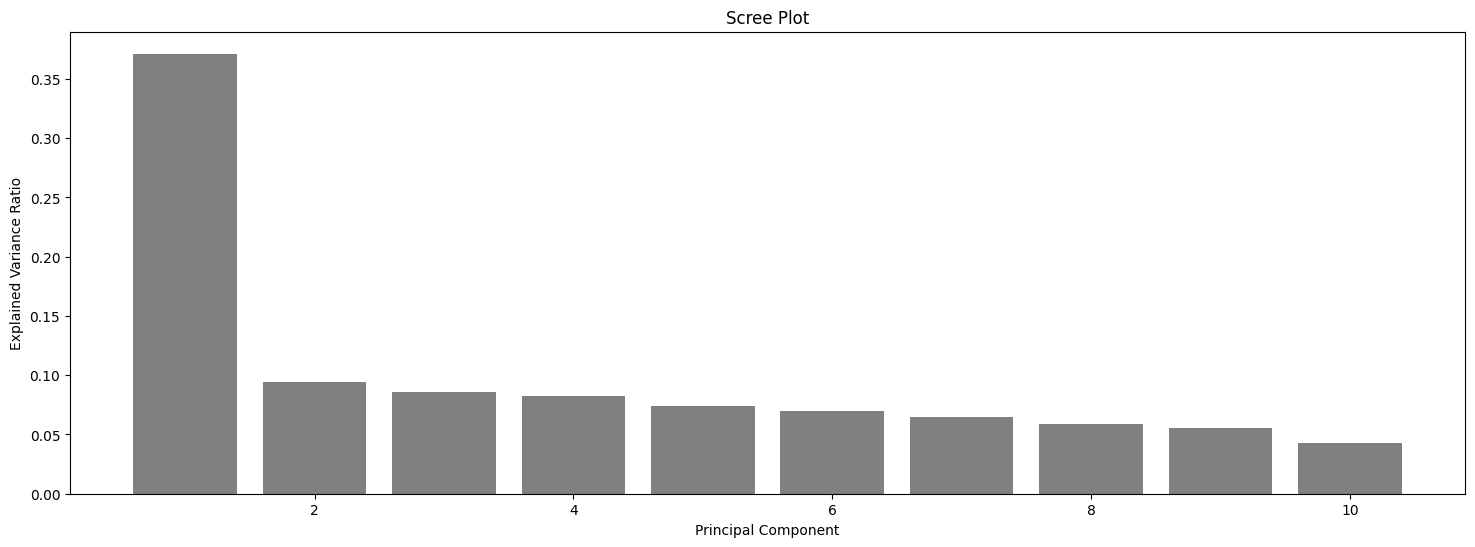

In [30]:
explained_var_c1 = newpca.explained_variance_ratio_
plt.figure(figsize=(18,6))
plt.bar(
    np.arange(1, len(explained_var_c1) + 1),
    explained_var_c1,color='grey'
)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.show()

For this case take k=1,2

Loadings

In [31]:
loadings_c1=pd.DataFrame(newpca.components_.T,index=c1.columns)
loadings_c1

,0,1,2,3,4,5,6,7,8,9
Ticker,,,,,,,,,,
AKAM,0.291631,-0.325018,0.305014,-0.241776,0.460724,0.581086,-0.131874,-0.272425,-0.080583,-0.098987
AMD,0.339726,0.206665,0.015459,-0.077117,0.094850,-0.290995,0.671598,-0.490567,-0.208126,-0.083656
ANET,0.352685,0.080718,0.040712,-0.129166,0.028181,0.246564,0.480014,0.682282,0.303998,0.028848
EPAM,0.318437,0.273906,-0.177558,-0.163008,0.486377,-0.365983,-0.374700,0.327962,-0.371197,-0.096032
FSLR,0.250585,0.155533,-0.145608,0.891665,0.193522,0.234023,-0.024540,-0.048460,0.002339,0.039694
FTNT,0.374335,-0.277600,-0.292023,-0.093979,-0.262268,0.038042,-0.066568,-0.039745,-0.244188,0.743527
GDDY,0.363548,0.004263,-0.114234,-0.086889,0.060676,-0.276554,-0.267463,-0.265442,0.790360,0.019698
GEN,0.247449,-0.329597,0.729920,0.255783,-0.158643,-0.411038,-0.074400,0.159437,-0.081986,0.011379
PANW,0.348560,-0.308321,-0.346102,0.010118,-0.458329,0.065138,-0.085467,0.029646,-0.152456,-0.646390


pc1 for loadings of c2

In [32]:
c1_pc1_loadings=loadings_c1.iloc[:, 0].sort_values(key=abs, ascending=False)
print(c1_pc1_loadings)

Ticker
FTNT    0.374335
GDDY    0.363548
ANET    0.352685
PANW    0.348560
AMD     0.339726
EPAM    0.318437
AKAM    0.291631
FSLR    0.250585
GEN     0.247449
SMCI    0.236511
Name: 0, dtype: float64


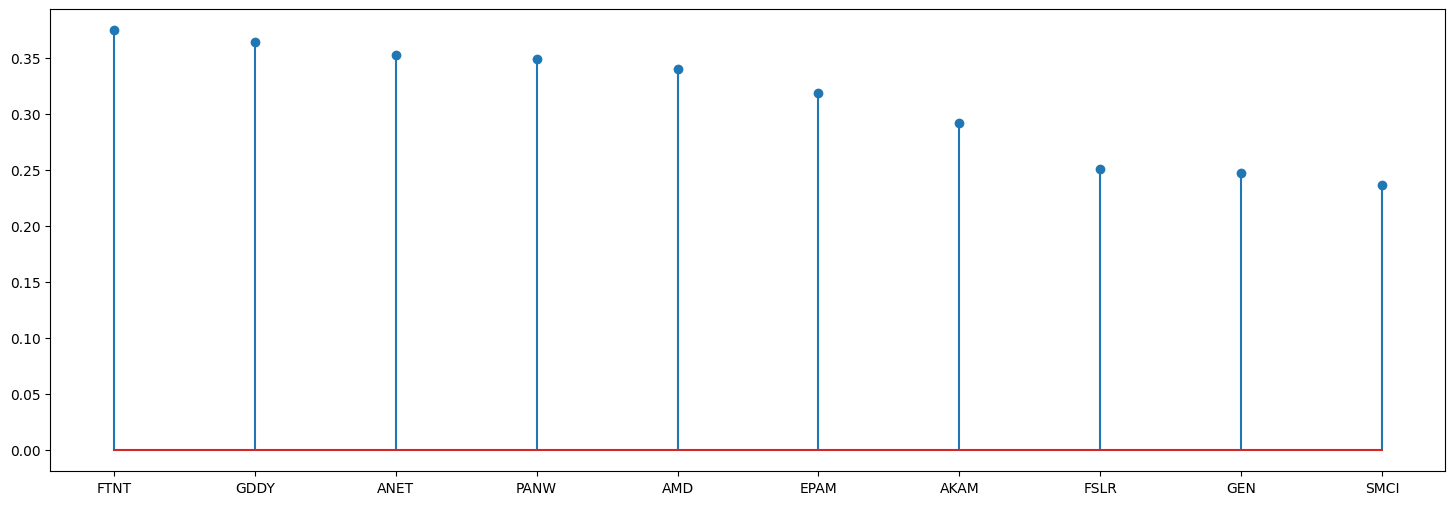

In [33]:
plt.figure(figsize=(18,6))
plt.stem(c1_pc1_loadings.index,c1_pc1_loadings.values)
plt.xticks()
plt.show()

pc2 for loadings of c2

In [34]:
c1_pc2_loadings=loadings_c1.iloc[:,1].sort_values(key=abs,ascending=False)
c1_pc2_loadings

Ticker
SMCI    0.682017
GEN    -0.329597
AKAM   -0.325018
PANW   -0.308321
FTNT   -0.277600
EPAM    0.273906
AMD     0.206665
FSLR    0.155533
ANET    0.080718
GDDY    0.004263
Name: 1, dtype: float64

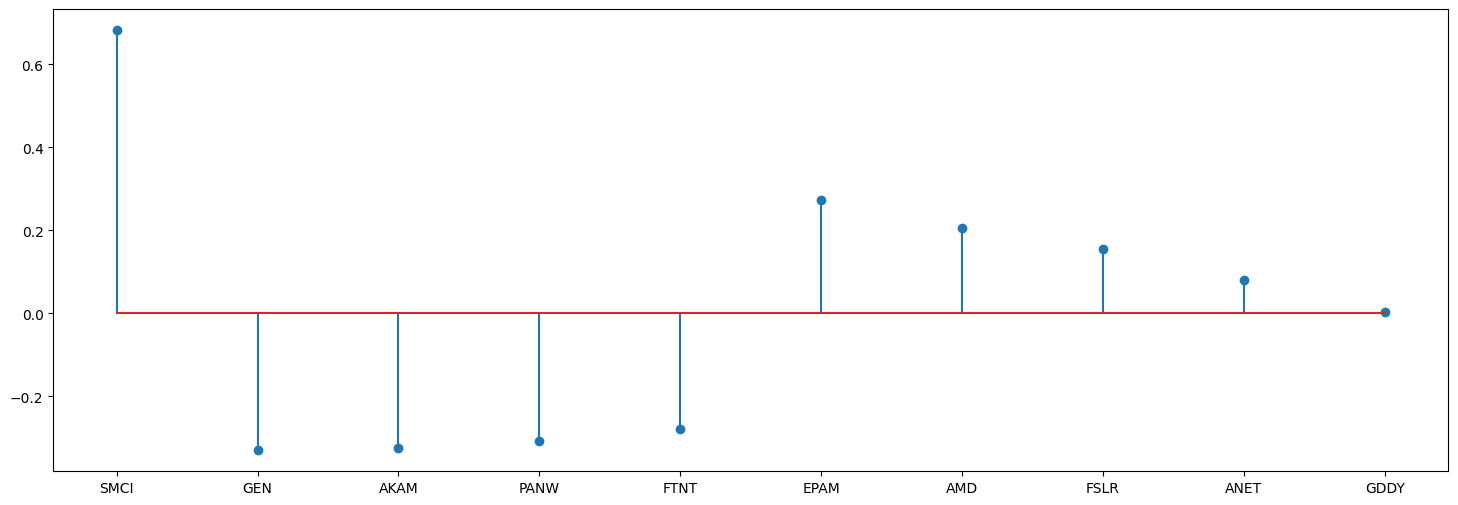

In [35]:
plt.figure(figsize=(18,6))
plt.stem(c1_pc2_loadings.index,c1_pc2_loadings.values)
plt.xticks()
plt.show()

Keep pairs with only large pc loadings and then form pairs with those for reducing run-time and wasting time on useless pairs.

In [36]:
prime_candi=c1_pc2_loadings[c1_pc2_loadings.abs()>0.15].index

In [37]:
prime_candi

Index(['SMCI', 'GEN', 'AKAM', 'PANW', 'FTNT', 'EPAM', 'AMD', 'FSLR'], dtype='object', name='Ticker')

Identify unique pairs

In [38]:
pairs=[]

for i in range(len(prime_candi)):
    for j in range(i+1,len(prime_candi)):
        pairs.append((prime_candi[i],prime_candi[j]))

* Engle-Granger test

In [39]:
for a,b in pairs:
    score,pvalue,_=coint(c1[a],c1[b])
    if pvalue<0.05:
        print('Good Pair🔍','P-value:',pvalue)

Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 0.0
Good Pair🔍 P-value: 3.255010194500274e-26
Good Pair🔍 P-value: 9.211132384947559e-21
Good Pair🔍 P-value: 1.4959865127236822e-20
Good Pair🔍 P-value: 5.974682215297089e-27
Good Pair🔍 P-value: 3.800697290937061e-27
Good Pair🔍 P-value: 0.0


Helping function to build spread with hedge ratio

In [40]:
def hedge_ratio(y,x):
    x=sm.add_constant(x)
    model=sm.OLS(y,x).fit()
    return model.params[1]
#pair=[('IBM','AMD')]test run

for a,b in pairs:
    beta=hedge_ratio(c1[a],c1[b])
    spread=c1[a]-beta*c1[b]
    spread_r=spread.diff().dropna()


Helping function for Half-Life filter

In [41]:
spread_lag=spread.shift(1).dropna()

reg=sm.OLS(spread_r,sm.add_constant(spread_lag)).fit()
halflife=-np.log(2)/reg.params.iloc[1]
pairs_info=[]
if 5<=halflife<=60:
    pairs_info.append({
        'A':a,
        'B':b,
        'beta':beta,
        'halflife':int(round(halflife))
    })

pairs_df=pd.DataFrame(pairs_info)

In [42]:
pairs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame


# This means there is no pair left to trade on, there was this exact same case for the other Clusters 1 and 2 as well telling us that cluster has no tradable pairs within them.